In [1]:
pip install gym==0.10

You should consider upgrading via the 'c:\Users\dcnlab\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 0.3392835855484009 0
20 0.009026920422911644 0
40 0.0051213959231972694 0
60 0.0032143560238182545 0
80 0.0051530348137021065 2
100 0.005524948239326477 11
120 0.006115078926086426 29
140 0.004381683189421892 49
160 0.005712475161999464 69
180 0.006691839545965195 89
200 0.004702466074377298 109
220 0.00572261493653059 129
240 0.0043838112615048885 149
260 0.007279540877789259 169
280 0.003960020374506712 189
300 0.0026439593639224768 209
320 0.003122718771919608 229
340 0.005665613804012537 249
360 0.0052947914227843285 269
380 0.006943428888916969 289
400 0.0017291678814217448 309
420 0.00177529186476022 329
440 0.004496419802308083 349
460 0.006097353529185057 369
480 0.0016924834344536066 389
500 0.00527480524033308 409
520 0.000993732362985611 429
540 0.006127363070845604 449
560 0.0013769217766821384 469
580 0.0008020584937185049 489
600 0.003774035954847932 509
620 0.001586402417

'plt.figure(figsize=(10,7))\nplt.plot(qval_record)\nplt.xlabel("Steps",fontsize=11)\nplt.ylabel("qval",fontsize=11)'

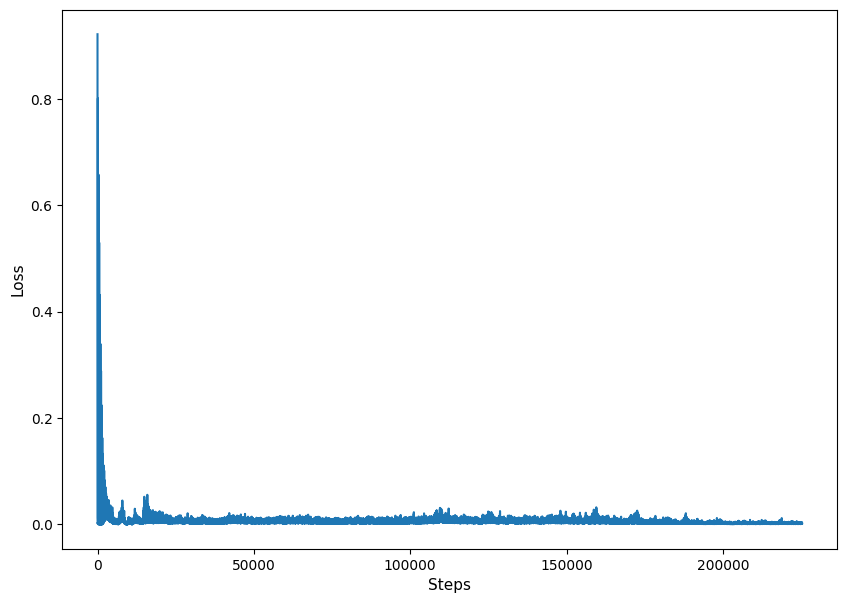

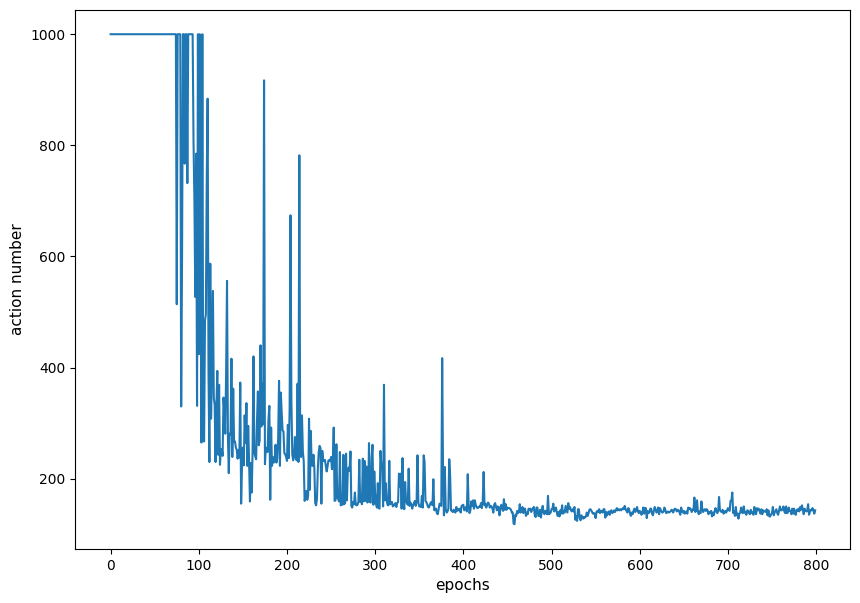

In [3]:
import copy
from sre_constants import SUCCESS
import numpy as np
import torch
import random
from matplotlib import pylab as plt
import gym
#from gym import wrappers 
from IPython.display import clear_output

"""L1 = 2
L2 = 150
Lv = 100
La = 100
Lv_output = 1
La_output = 3
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, Lv),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, La),
    torch.nn.ReLU(),
    torch.nn.Linear(Lv,Lv_output),
    torch.nn.Linear(La,La_output),
    
)"""

class model_t(torch.nn.Module):
    def __init__(self):
        super(model_t, self).__init__()

        self.fc1 = torch.nn.Linear(2, 150)
        self.relu = torch.nn.ReLU()
        self.fc_value = torch.nn.Linear(150, 100)
        self.fc_adv = torch.nn.Linear(150, 100)

        self.value = torch.nn.Linear(100, 1)
        self.adv = torch.nn.Linear(100, 3)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)
        advAverage = adv.mean(dim=-1, keepdim=True)
        Q = value + adv - advAverage

        return Q

"""class model_t(torch.nn.Module):
    def __init__(self):                                                         
        super(model_t, self).__init__()                                             

        self.feature_layer = torch.nn.Sequential(
            torch.nn.Linear(2, 150),                                                
            torch.nn.ReLU(),          
            torch.nn.Linear(150, 100),                                                
            torch.nn.ReLU(), 
        )
        
        self.advantage_layer = torch.nn.Sequential(
            torch.nn.Linear(100, 3),
            #torch.nn.ReLU(),                                                                            
        )
        
        self.value_layer = torch.nn.Sequential(
            torch.nn.Linear(100, 1),
            #torch.nn.ReLU(),                                                                                
        )
                                   
    def forward(self, x):                                                       
        feature = self.feature_layer(x)           
        value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)
                                            
        q = value + advantage - advantage.mean(dim=-1, keepdim=True)
        
        return q"""

model=model_t()
model2 = copy.deepcopy(model) #target network
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.6

env = gym.envs.make('MountainCar-v0')
env = env.unwrapped
#env = wrappers.Monitor(env,"C:\testml\video",video_callable=lambda count:count%10==0)
#env.Monitor.start('C:\testml\video',video_callable=lambda count: count % 10 == 0)

from collections import deque
epochs = 800 #訓練次數
losses = []
step_num = []
qval_record=[]
mem_size = 1000 
batch_size = 64 #batch_size
replay = deque(maxlen=mem_size) #replay buffer
max_moves = 1000 #每場遊戲最多可以走幾步
sync_freq = 200
success_flag=0
success_num=0
j=0
for i in range(epochs):
    state1_ = env.reset()
    state1 = torch.from_numpy(state1_).float()
    status = 1
    success_flag=0
    mov = 0     #記錄移動的步數
    while(status == 1): 
        j += 1
        mov += 1
        qval = model(state1) #輸出各動作的Q值
        #print(qval,i)
        qval_ = qval.data.numpy()
        #qval_record.append(np.max(qval_))
        if (random.random() < epsilon):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)
        state2_, reward , done , info= env.step(action_)
        #env.render() 
        #print(state2_)
        """
        if reward != -1:
            #step_num.append(mov)
            success_flag=1
            success_num+=1
            reward=200
        """

        if mov == 700 :
            reward = reward -  0.5
        if state2_[0] >= -0.4 :
            reward +=  0.2 + state2_[0]
        if state2_[1] >= 0.02 :
            reward +=   0.2 + state2_[1]*10

        if state2_[0] > 0.5 and success_flag == 0:
            status = 0
            #reward += 20
            success_num+=1
            step_num.append(mov)
            success_flag=1
        
        #if state2_[0] > 0.5:
                #reward = 5
        #elif state2_[0] <= -0.6:
            #reward = -1 + state2_[0]
        state2 = torch.from_numpy(state2_).float()
        #print(i)
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2 
        #print(state1)
        #print(len(replay),batch_size)     

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch_ = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch_ = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            state1_batch = torch.reshape(state1_batch_, (64, 2))
            state2_batch = torch.reshape(state2_batch_, (64, 2))

            Q1 = model(state1_batch) 
            with torch.no_grad():     
                Q2 = model2(state2_batch) 
            Y = reward_batch + gamma * (1-done_batch)*torch.max(Q2,dim=1)[0]
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            losses.append(loss.item())    

            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
            
        if reward == 200 or mov > max_moves:
            status = 0 
            mov = 0
        #losses.append(loss.item())  
    if epsilon > 0.001: 
        epsilon -= (1/epochs) 
    """if i % 100 == 0:
        if i!=0 and i%1000 == 0 :
            print(i,loss)
        else:
            print(i)"""
    if success_flag == 0:
        step_num.append(1000)
    if i%20 == 0:
      print(i, loss.item(),success_num)
    #print('\r')
    #print(i, loss.item(),success_num)
    #print('\r\b')
#env.close()
#test_model(model)
print(i, loss.item(),success_num)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

plt.figure(figsize=(10,7))
plt.plot(step_num)
plt.xlabel("epochs",fontsize=11)
plt.ylabel("action number",fontsize=11)

"""plt.figure(figsize=(10,7))
plt.plot(qval_record)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("qval",fontsize=11)"""




In [ ]:
"""def test_model(model):
  i = 0
  env = gym.envs.make('MountainCar-v0')
  env = env.unwrapped
  for i in range(10):
    state3_ = env.reset()  
    env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0
    while(status == 1):    
      mov += 1
      qval = model(state3)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      print(action_)
      observation, reward, done, info = env.step(action_)
      state3=torch.from_numpy(observation).float()
      #print(action_,reward,done)
      #print(observation)
      env.render()
      if mov >= 1000:
        status=0
      #time.sleep(0.02)
      #env.render()    
    print(i)
  env.close()"""

In [3]:

#env = gym.envs.make('MountainCar-v0')
#env = env.unwrapped
test_s=0
for i in range(1000):
    state3_ = env.reset()  
    #env.render()
    state3 = torch.from_numpy(state3_).float()
    status = 1
    mov = 0 
    while(status == 1):    
        mov += 1
        qval = model(state3)
        qval_ = qval.data.numpy()
        """if (random.random() < 0.1):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)"""
        action_ = np.argmax(qval_)
        #state2_, reward , done , info= env.step(action_)
        #action_ = np.argmax(qval_) 
        #print(action_)
        observation, reward, done, info = env.step(action_)
        state3=torch.from_numpy(observation).float()
        #print(action_,reward,done)
        #print(observation)
        #env.render()
        if observation[0] > 0.5 :
            status = 0
            test_s += 1
        if mov >= 1000:
            status=0
        
        #env.render()    
    #print(i)
print(test_s)
#env.close()

1000


In [8]:
#test_model(model)
torch.max(Q2,dim=1)

torch.return_types.max(
values=tensor([-8.7114e+00, -1.0333e+00, -7.6228e+00, -9.1838e+00,  1.0262e-01,
        -9.5980e+00, -9.9537e+00, -9.4162e+00, -1.0115e+01, -9.7184e+00,
        -1.0019e+01, -3.0594e+00,  3.8749e+00, -2.4921e+00, -9.0665e+00,
        -7.6211e+00,  6.1840e-03, -9.8353e+00, -8.6971e+00,  2.0545e-01,
        -9.8781e+00, -1.2485e+00, -9.3591e+00,  2.0003e+00, -9.1603e+00,
        -1.3314e+00, -8.6041e+00, -9.1247e+00,  1.7523e+00, -9.2924e+00,
        -7.6208e+00, -2.0586e+00, -5.9245e+00,  4.4959e-01, -8.9840e+00,
         2.4871e+00, -9.8220e+00, -9.2758e+00, -3.7557e-01, -9.5640e+00,
        -9.8188e+00, -2.1091e+00, -7.5447e+00, -6.8960e+00, -9.3238e+00,
        -9.5077e+00, -9.5818e+00, -4.9839e+00, -9.8610e+00, -8.1938e+00,
        -9.1308e+00, -2.1215e+00,  4.9930e+00, -9.3362e+00, -1.0052e+01,
        -9.2301e+00, -8.5777e+00, -2.1718e+00, -9.5399e+00, -9.8075e+00,
        -9.3001e+00, -9.6318e+00, -9.7413e+00, -9.8237e+00]),
indices=tensor([2, 2, 2, 2, 2, 

In [7]:
Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()

tensor([ -8.7168,  -1.1331,  -7.9114,  -9.3069,  -0.0377,  -9.6666,  -9.8953,
         -9.4977, -10.1337,  -9.6047,  -9.9466,  -3.2476,   3.3750,  -2.7214,
         -9.2228,  -7.8938,  -0.1205,  -9.9169,  -8.8083,  -0.1461, -10.0726,
         -1.5243,  -9.4363,   1.6140,  -9.3239,  -1.5642,  -8.8080,  -9.1019,
          1.6011,  -9.4252,  -7.4832,  -2.1203,  -6.2754,   0.0669,  -9.1189,
          2.0343,  -9.8745,  -9.3220,  -0.5872,  -9.6327,  -9.8769,  -2.1775,
         -7.3503,  -7.2458,  -9.2629,  -9.6110,  -9.6316,  -5.4575,  -9.7425,
         -8.4473,  -9.2098,  -2.1937,   4.6060,  -9.4080,  -9.9468,  -9.3151,
         -8.7582,  -2.2013,  -9.6201, -10.0013,  -9.3812,  -9.6999,  -9.8026,
         -9.8752], grad_fn=<SqueezeBackward0>)